# AnimationWidget. Basics

Introduction
============

This notebook presents the animationwidget. It provides a periodic timer. This timer delivers a pulse that can drive animations in a notebook.

Under the hull, this widget uses the javascript [setTimeout() function](http://www.w3schools.com/jsref/met_win_settimeout.asp) to periodically change a value in a Python model. This value can then be connected to other widgets.

For more details about widgets , I recommend the [PyDataParis2016 tutorial by Sylvain Corlet](https://github.com/SylvainCorlay/PyDataParis2016/blob/master/Index.ipynb)

In [1]:
from __future__ import print_function
import animationwidget

In [2]:
w = animationwidget.AnimationWidget()

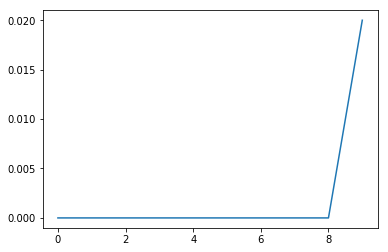

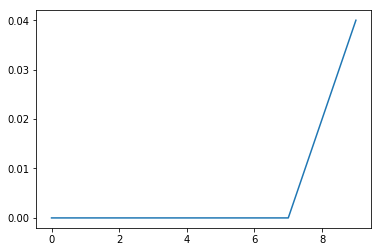

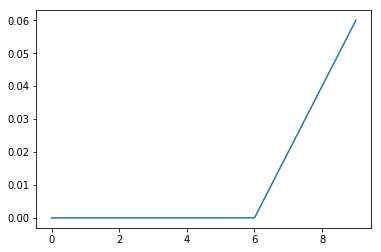

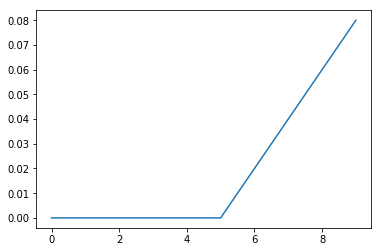

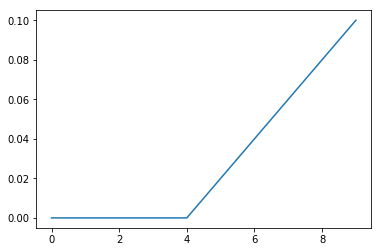

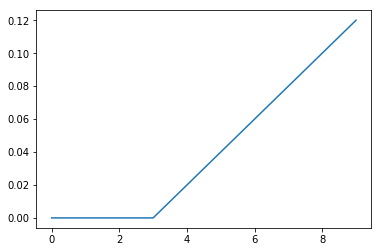

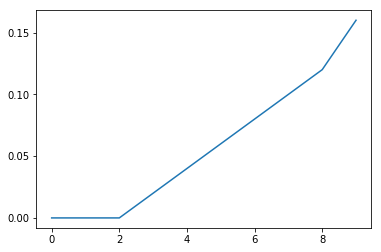

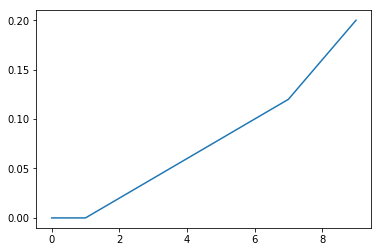

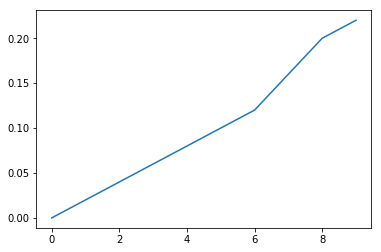

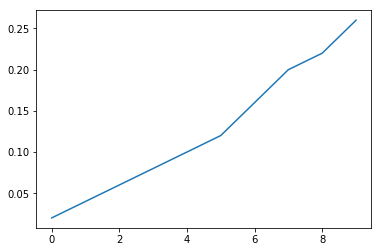

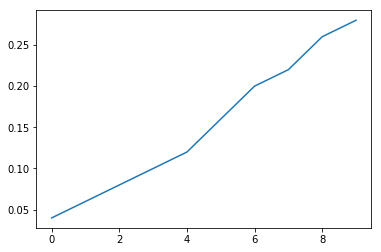

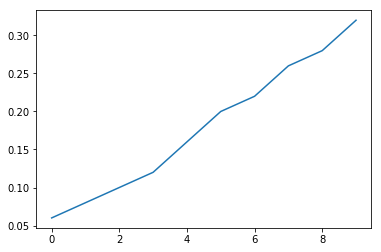

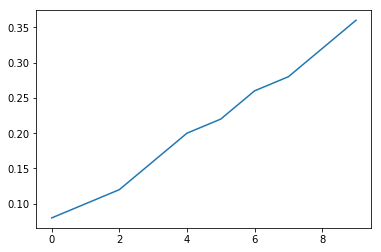

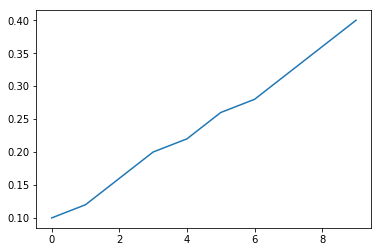

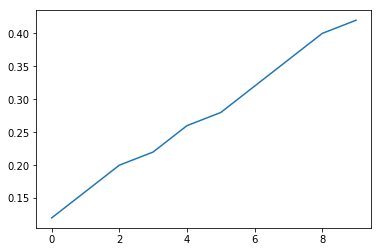

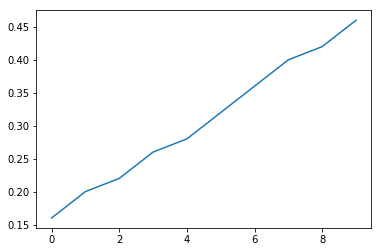

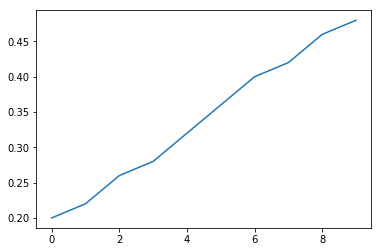

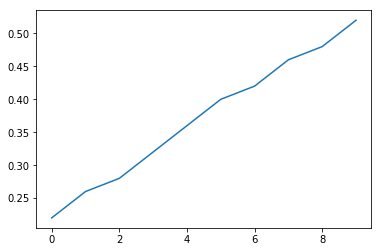

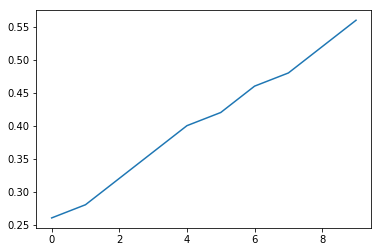

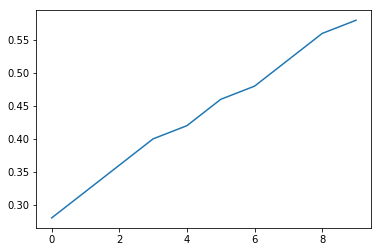

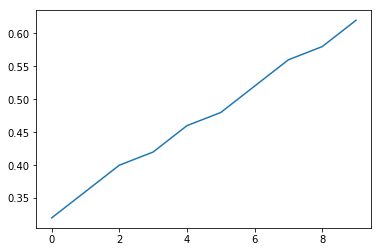

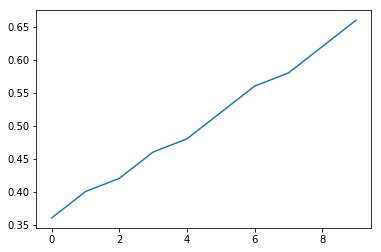

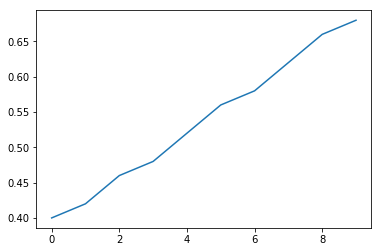

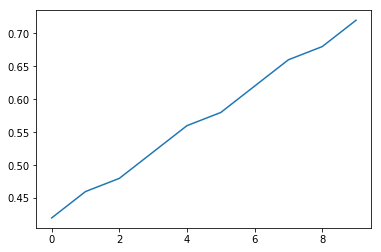

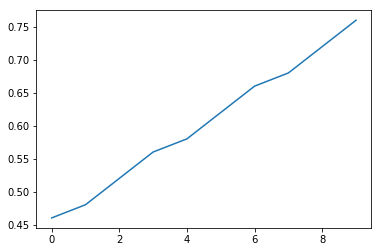

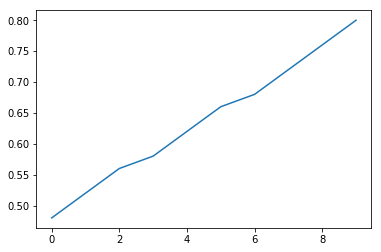

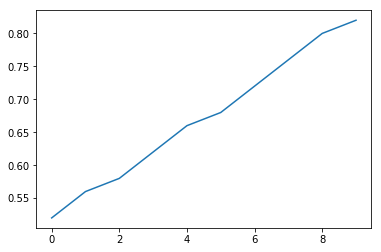

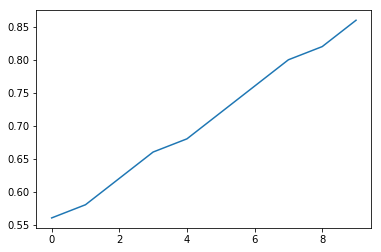

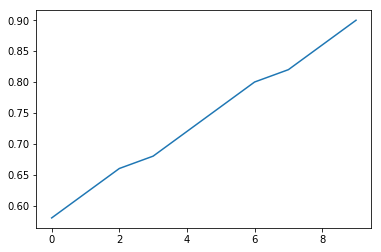

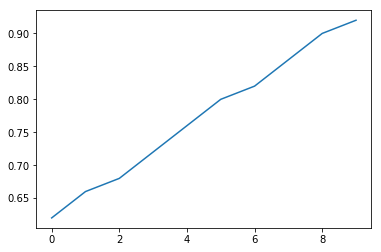

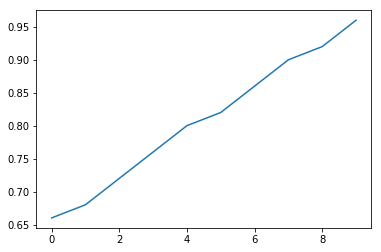

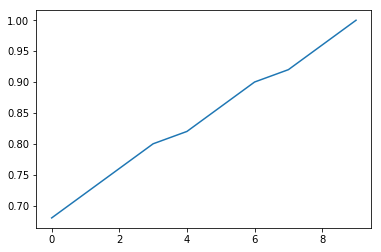

In [3]:
w

The widget has the following attributes:
* value: a float in [0,1] interval. The timer periodically changes this value
* run: a boolean that triggers the timer. 
* period: signal period (in milliseconds). It is the time for the counter to go from 0.0 to 1.0
* sampling: sampling rate, interval between two pulses of the trigger.

In [6]:
w.run = True

In [4]:
import numpy as np

class RingBufferArray(object):
    """
    A class that keep a window of the N last values
    """
    def __init__(self, size, dtype):
        """
        :param size: windows size
        :param dtype: data type
        """
        self._values = np.zeros(size, dtype=dtype)
        self._start_index = 0
        self._len = size
        

    def __call__(self, new_value):
        """
        Add the new value to the window. Return the full signal
        """
        # Push value
        self._values[self._start_index] = new_value
        self._start_index = (self._start_index + 1) % self._len
        return np.append(self._values[self._start_index:], self._values[:self._start_index])


In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
from traitlets import dlink

def gen_plot_fun(size):
    x = np.arange(size)
    buff = RingBufferArray(size, np.float64)
    
    def inner(value):
        plt.plot(x, buff(value['new']))
        plt.show()
    return inner
        
plot_fun = gen_plot_fun(10)
w.observe(plot_fun, names='value')